<a href="https://colab.research.google.com/github/LCaravaggio/NLP/blob/main/07_TopicModelling/KMeans_con_ngrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

In [4]:
from google.colab import userdata
import json

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {
    'username': userdata.get('KAGGLE_USER'),
    'key': userdata.get('KAGGLE_KEY')}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d zynicide/wine-reviews

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 96% 49.0M/50.9M [00:00<00:00, 96.1MB/s]
100% 50.9M/50.9M [00:00<00:00, 81.0MB/s]


In [5]:
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [6]:
winedf = pd.read_csv('/content/winemag-data_first150k.csv')
winedf.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


# EDA

In [7]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


Ojo que hay duplicados en el dataset, así que los eliminamos

In [9]:
winedf[winedf['description'].duplicated(keep = False)].sort_values('description').head(7)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
147725,147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
62345,62345,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
74993,74993,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
18803,18803,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
26530,26530,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
84730,84730,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
53110,53110,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister


In [10]:
winedf = winedf.drop_duplicates('description')

In [11]:
winedf.shape

(97821, 11)

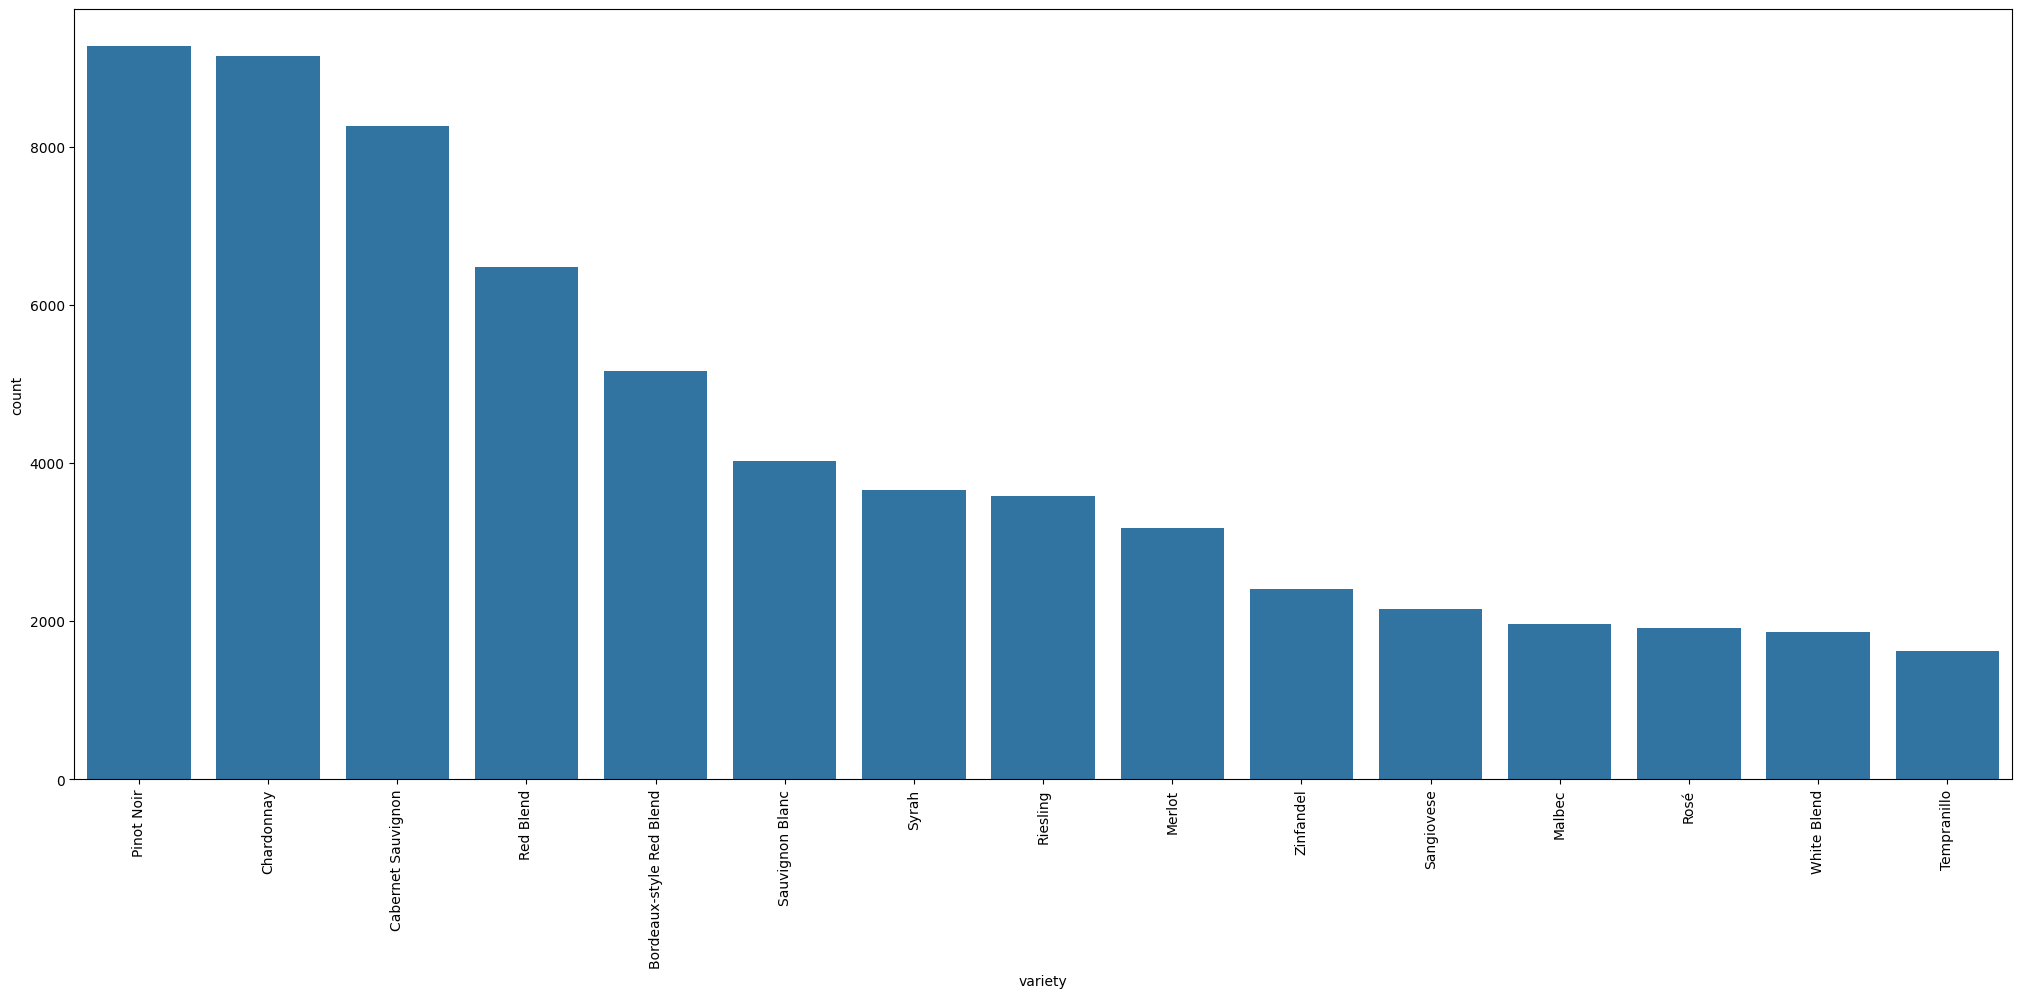

In [12]:
variety_df = winedf.groupby('variety').filter(lambda x: len(x) > 1500)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [13]:
variety_df['variety'].unique()

array(['Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Rosé', 'Syrah',
       'Sangiovese', 'Red Blend', 'Riesling', 'White Blend', 'Zinfandel',
       'Bordeaux-style Red Blend', 'Merlot'], dtype=object)

In [14]:
len(variety_df['variety'].unique())

15

# NLP

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer

In [182]:
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range=(1,1), max_df=200, min_df=1)
#vectorizer = TfidfVectorizer(stop_words = stop_words, ngram_range=(1,1))
#vectorizer = CountVectorizer(stop_words = stop_words, ngram_range=(1,1))
X = vectorizer.fit_transform(desc)

In [183]:
word_features = vectorizer.get_feature_names_out()
len(word_features)

23773

In [134]:
word_features[550:575]

array(['accentuates', 'accentuating', 'accept', 'acceptable',
       'acceptance', 'access', 'accessed', 'accesses', 'accessibile',
       'accessibility', 'accessibly', 'accessorized', 'acciaiolo',
       'accident', 'acciderba', 'acclaim', 'acclaimed', 'accolade',
       'accolades', 'accommodate', 'accommodating', 'accompanied',
       'accompanies', 'accompaniment', 'accompaniments'], dtype=object)

In [135]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [206]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = list(text.ENGLISH_STOP_WORDS.union(punc))

In [216]:
vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer = tokenize, token_pattern=None, max_features = 1000)
X = vectorizer.fit_transform(desc)
word_features = vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [219]:
len(word_features)

1000

In [220]:
word_features[:20]

array(['abov', 'accent', 'access', 'accompani', 'acid', 'ad', 'add',
       'addit', 'afford', 'aftertast', 'age', 'ageabl', 'ager',
       'ageworthi', 'aggress', 'air', 'alcohol', 'allow', 'almond',
       'alongsid'], dtype=object)

# KMeans

In [226]:
kmeans = KMeans(n_clusters = 10, n_init='auto')
kmeans.fit(X)

KMeans(n_clusters=10, n_init='auto')

In [227]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

In [228]:
for num, centroid in enumerate(common_words):
    print(str(num+1) + ' : ' + ', '.join(word_features[word] for word in centroid))

1 : pinot, noir, cherri, cola, silki, raspberri, flavor, dri, acid, drink
2 : cabernet, sauvignon, blend, merlot, franc, petit, verdot, wine, syrah, fruit
3 : wine, fruit, age, acid, ripe, wood, tannin, structur, rich, year
4 : blackberri, flavor, cherri, dri, currant, tannin, soft, drink, wine, rich
5 : wine, fruit, flavor, cherri, finish, red, light, raspberri, acid, tannin
6 : sampl, barrel, wine, tannin, fruit, ripe, wood, structur, juici, veri
7 : chardonnay, pineappl, flavor, butter, oak, vanilla, toast, pear, acid, peach
8 : appl, citrus, finish, flavor, lemon, lime, acid, fresh, peach, wine
9 : berri, aroma, finish, palat, plum, flavor, feel, herbal, red, nose
10 : black, cherri, palat, aroma, tannin, fruit, dark, plum, finish, spice


In [235]:
from collections import Counter


cluster_labels = kmeans.labels_
cluster_counts = Counter(cluster_labels)

for cluster_num in sorted(cluster_counts.keys()):
    print(f"Cluster {cluster_num+1}: {cluster_counts[cluster_num]}")

Cluster 1: 3897
Cluster 2: 3403
Cluster 3: 6596
Cluster 4: 8837
Cluster 5: 14417
Cluster 6: 1085
Cluster 7: 5034
Cluster 8: 10054
Cluster 9: 5452
Cluster 10: 5961


In [229]:
variety_df['cluster'] = kmeans.labels_

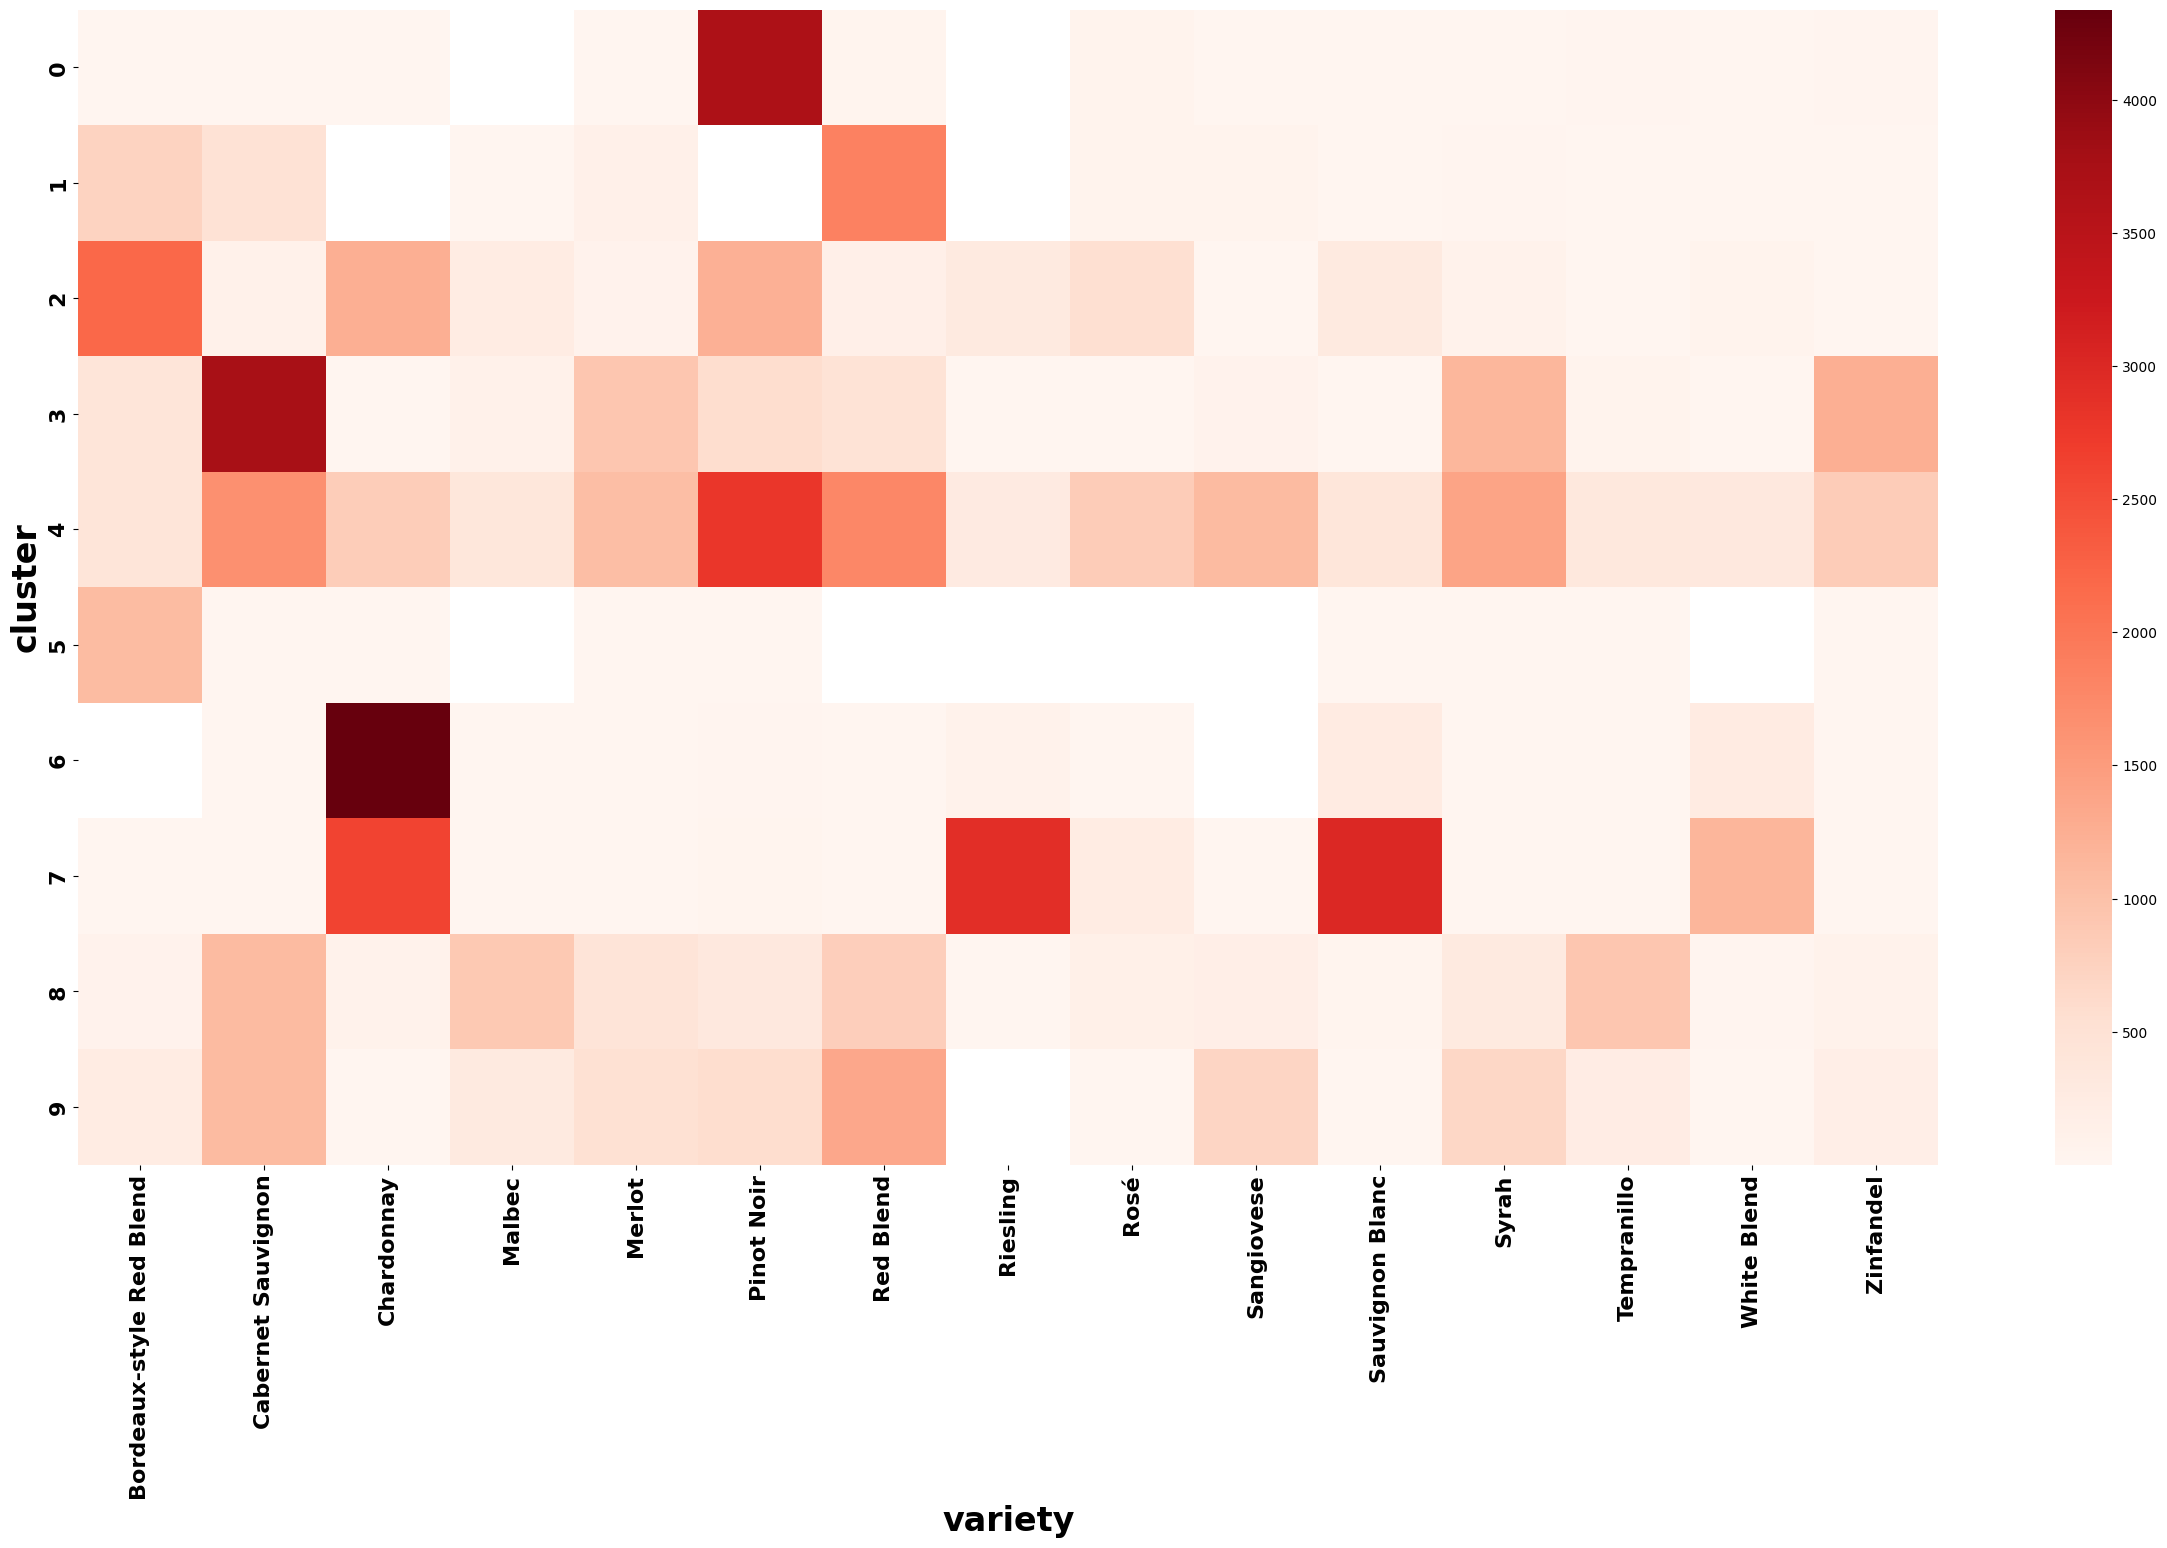

In [230]:
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")